In [1]:
import torch
from torch import nn
import scipy.stats as stats
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [15]:
plt.rc("axes",
    axisbelow = True,
    labelsize = 18,
    titlesize = 20
)
plt.rc('text', usetex=True)
plt.rc("font", family = "sans-serif")
plt.rc("image", cmap = "viridis")

# plt.rc("legend",
#     edgecolor = "k",
#     fontsize = 15,
#     framealpha = 1.0
# )
# plt.rc("xtick", labelsize = 12)
# plt.rc("ytick", labelsize = 12)

In [184]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(3, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        output = self.model(x)
        return output

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(3, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 3),
        )
    def forward(self, x):
        output = self.model(x)
        return output

def create_training_data(N, rhos, sig_diag, m): 
    train_data_length = N
    train_data = torch.zeros((train_data_length, 3))
    rho01=rhos[0];rho02=rhos[1];rho12=rhos[2]
    sigma = [[sig_diag[0], rho01, rho02], [rho01, sig_diag[1], rho12], [rho02, rho12, sig_diag[2]]]
    mu = m
    dstr = stats.multivariate_normal(mean=mu, cov=sigma)
    x1=[];x2=[];x3=[]
    for i in range(train_data_length):
        sample=dstr.rvs()
        x1.append(sample[0]);x2.append(sample[1]);x3.append(sample[2])
    plt.hist(x1, bins=100, density=True);plt.hist(x2, bins=100, density=True);plt.hist(x3, bins=100, density=True); plt.show()
    train_data[:, 0] = torch.tensor(x1)
    train_data[:, 1] = torch.tensor(x2)
    train_data[:, 2] = torch.tensor(x3)
    return train_data

def addNoise(train_data, eps_mu, eps_sig):
    x1 = train_data[:,0]
    x2 = train_data[:,1]
    x3 = train_data[:,2]
    eps1 = np.random.normal(eps_mu, eps_sig, len(train_data))
    eps2 = np.random.normal(eps_mu, eps_sig, len(train_data))
    eps3 = np.random.normal(eps_mu, eps_sig, len(train_data))
    x1 += eps1; x2 += eps2; x3 += eps3
    plt.hist(x1.numpy(),bins = 100, density=True); plt.hist(x2.numpy(),bins = 100, density=True)
    plt.hist(x3.numpy(),bins = 100, density=True); plt.show()
    train_data[:, 0] = x1
    train_data[:, 0] = x2
    train_data[:, 0] = x3
    return train_data

def save(data, filename):
    data_df = pd.DataFrame(data)
    data_df.to_csv(filename, index=False)
    return

def chi2_distance(A, B):
    chi = 0.5 * np.sum([((a - b) ** 2) / (a + b)
                      for (a, b) in zip(A, B)])
    return chi

def create_training_set(train_data):
    train_labels = torch.zeros(len(train_data))
    train_set = [(train_data[i], train_labels[i]) for i in range(len(train_data))]
    return train_set

In [58]:
noiseExp_ks = []; noiseExp_kl = []; noiseExp_cs = []
eps_space = [0.0001, 0.001, 0.01, 0.1, 1, 10]

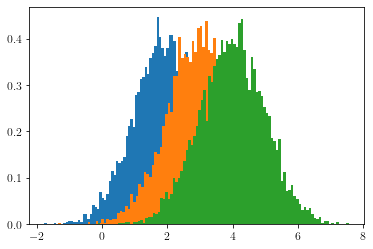

In [185]:
train_data = create_training_data(6000, [0,0,0], [1,1,1], [2,3,4])
denoise_data = train_data

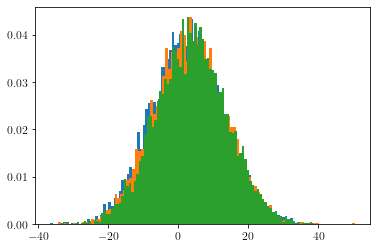

In [186]:
train_data = addNoise(train_data, 0, eps_space[5])

In [187]:
train_set = create_training_set(train_data)

In [188]:
batch_size =75
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

discriminator = Discriminator()
generator = Generator()

In [189]:
lr = 0.001
num_epochs = 500
loss_function = nn.BCELoss()
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)



In [190]:
for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, 3))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 3))

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if epoch % 10 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")



Epoch: 0 Loss D.: 0.2991866171360016
Epoch: 0 Loss G.: 3.006117343902588
Epoch: 10 Loss D.: 0.9366472363471985
Epoch: 10 Loss G.: 0.8276920914649963
Epoch: 20 Loss D.: 0.6389436721801758
Epoch: 20 Loss G.: 0.7755023241043091
Epoch: 30 Loss D.: 0.5091719627380371
Epoch: 30 Loss G.: 1.1841357946395874
Epoch: 40 Loss D.: 0.668285071849823
Epoch: 40 Loss G.: 0.6933118104934692
Epoch: 50 Loss D.: 0.7549148797988892
Epoch: 50 Loss G.: 0.5958625674247742
Epoch: 60 Loss D.: 0.7383529543876648
Epoch: 60 Loss G.: 0.794817328453064
Epoch: 70 Loss D.: 0.7051903009414673
Epoch: 70 Loss G.: 0.7840997576713562
Epoch: 80 Loss D.: 0.7101016640663147
Epoch: 80 Loss G.: 0.6933662295341492
Epoch: 90 Loss D.: 0.7165210247039795
Epoch: 90 Loss G.: 0.745438277721405
Epoch: 100 Loss D.: 0.6911965012550354
Epoch: 100 Loss G.: 0.6248822212219238
Epoch: 110 Loss D.: 0.6940441131591797
Epoch: 110 Loss G.: 0.7378517389297485
Epoch: 120 Loss D.: 0.6925605535507202
Epoch: 120 Loss G.: 0.692694902420044
Epoch: 130 Lo

In [191]:
latent_space_samples = torch.randn(len(train_data), 3)
generated_samples = generator(latent_space_samples)
generated_samples = generated_samples.detach()

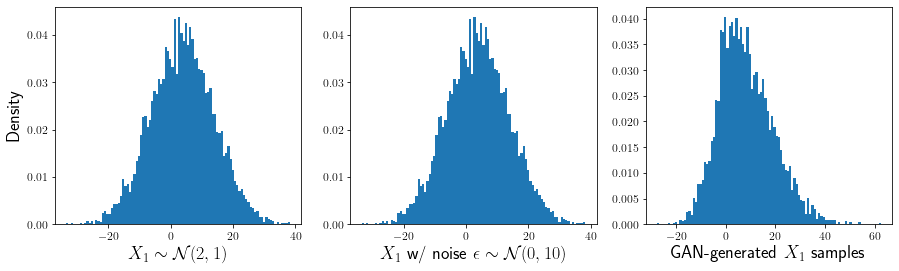

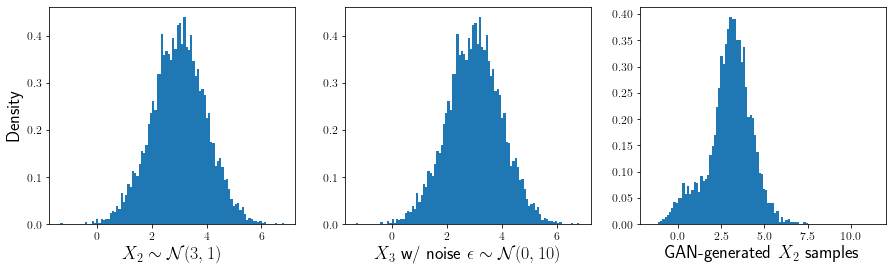

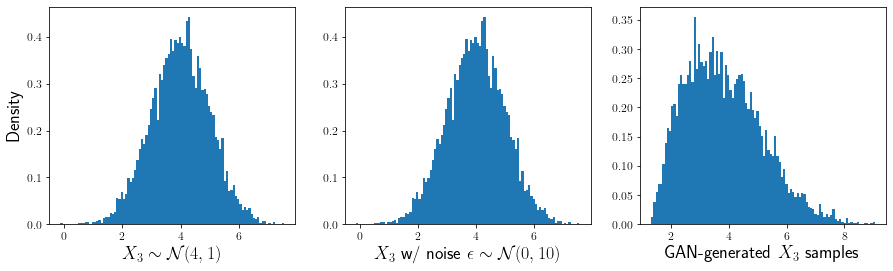

In [201]:
plt.figure(figsize=(15,4))


l0=denoise_data[:, 0].tolist()
plt.subplot(131)
plt.hist(l0,100,density=True)
plt.xlabel('$X_1 \sim \mathcal{N}(2,1)$')
plt.ylabel('Density')

l1=train_data[:, 0].tolist()
plt.subplot(132)
plt.hist(l1,100,density=True)
plt.xlabel('$X_1$ w/ noise $\epsilon \sim \mathcal{N}(0,10)$')

l2=generated_samples[:, 0].tolist()
plt.subplot(133)
plt.hist(l2,100,density=True)
plt.xlabel('GAN-generated $X_1$ samples')

plt.show()





plt.figure(figsize=(15,4))

l0=denoise_data[:, 1].tolist()
plt.subplot(131)
plt.hist(l0,100,density=True)
plt.xlabel('$X_2 \sim \mathcal{N}(3,1)$')
plt.ylabel('Density')

l1=train_data[:, 1].tolist()
plt.subplot(132)
plt.hist(l1,100,density=True)
plt.xlabel('$X_3$ w/ noise $\epsilon \sim \mathcal{N}(0,10)$')

l2=generated_samples[:, 1].tolist()
plt.subplot(133)
plt.hist(l2,100,density=True)
plt.xlabel('GAN-generated $X_2$ samples')

plt.show()







plt.figure(figsize=(15,4))

l0=denoise_data[:, 2].tolist()
plt.subplot(131)
plt.hist(l0,100,density=True)
plt.xlabel('$X_3 \sim \mathcal{N}(4,1)$')
plt.ylabel('Density')

l1=train_data[:, 2].tolist()
plt.subplot(132)
plt.hist(l1,100,density=True)
plt.xlabel('$X_3$ w/ noise $\epsilon \sim \mathcal{N}(0,10)$')

l2=generated_samples[:, 2].tolist()
plt.subplot(133)
plt.hist(l2,100,density=True)
plt.xlabel('GAN-generated $X_3$ samples')

plt.show()

# Analysis

In [162]:
from scipy.stats import kstest
from scipy.special import rel_entr

In [135]:
ks_tests = []
kl_tests = []
cs_tests = []
num_x = train_data.shape[1]
for i in range(num_x):
    ks_tests.append(kstest(generated_samples[:,i], denoise_data[:,i])[0])
    kl_tests.append(sum(rel_entr(generated_samples[:,i], denoise_data[:,i])))
    cs_tests.append(chi2_distance(generated_samples[:,i], denoise_data[:,i]))
print(ks_tests,'\n******\n', kl_tests, '\n******\n',cs_tests)

[0.035333333333333335, 0.1855, 0.43816666666666665] 
******
 [tensor(inf), tensor(inf), tensor(6971.9912)] 
******
 [195573.359375, 794.6483154296875, 790.8707275390625]


In [136]:
noiseExp_ks.append(ks_tests); noiseExp_kl.append(kl_tests); noiseExp_cs.append(cs_tests)

In [137]:
noiseExp_ks

[[0.048666666666666664, 0.16033333333333333, 0.051833333333333335],
 [0.15283333333333332, 0.206, 0.167],
 [0.25583333333333336, 0.2525, 0.18416666666666667],
 [0.25833333333333336, 0.16533333333333333, 0.23066666666666666],
 [0.14183333333333334, 0.327, 0.16833333333333333],
 [0.035333333333333335, 0.1855, 0.43816666666666665]]

In [138]:
ksx1 = [i[0] for i in noiseExp_ks]
ksx2 = [i[1] for i in noiseExp_ks]
ksx3 = [i[2] for i in noiseExp_ks]

Text(0.5, 1.0, 'Effect of error variance in training data on KS statistic')

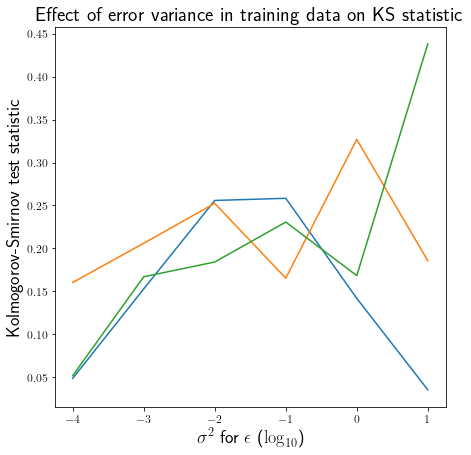

In [144]:
plt.figure(figsize=(7,7))
plt.plot(np.log10(eps_space),ksx1)
plt.plot(np.log10(eps_space),ksx2)
plt.plot(np.log10(eps_space),ksx3)
plt.xlabel('$\sigma^2$ for $\epsilon$ ($\log_{10}$)')
plt.ylabel('Kolmogorov-Smirnov test statistic')
plt.title('Effect of error variance in training data on KS statistic')